# WS - Google Stocks Prediction (RNN)

The problem to solve is Google Stocks prediction - regression (time series).

In [1]:
# Import libraries:

import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.layers import RepeatVector

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# 1. Dataset

The dataset is already divided in train and test.

There are multiple columns. You work only with HIGH.

In [3]:
# Load the dataset:

# Path to the dataset on My Drive Google:
#box_train = './drive/My Drive/My Folder/RNN Google/Google_Stock_Price_Train.csv'
#box_test = './drive/My Drive/My Folder/RNN Google/Google_Stock_Price_Test.csv'

#train = pd.read_csv(box_train, sep=",")
#test = pd.read_csv(box_test, sep=",")

# Directly reading the csv. file:
train = pd.read_csv('Google_Stock_Price_Train.csv')
test = pd.read_csv('Google_Stock_Price_Test.csv')

In [4]:
# Check the status of train dataset after the load procedure:

train

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [5]:
# Check the status of test dataset after the load procedure:

test

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"
5,1/10/2017,807.86,809.13,803.51,804.79,"1,176,800"
6,1/11/2017,805.00,808.15,801.37,807.91,"1,065,900"
7,1/12/2017,807.14,807.39,799.17,806.36,"1,353,100"
8,1/13/2017,807.48,811.22,806.69,807.88,"1,099,200"
9,1/17/2017,807.08,807.14,800.37,804.61,"1,362,100"


In [6]:
# Reconstructing the train and test datasets with only 'High' column:

# Isolating the column 'High':
iso_col = ['High']

# Reconstructed train set:
train = pd.DataFrame(data = train, columns = iso_col)

# Reconstructed test set:
test = pd.DataFrame(data = test, columns = iso_col)

In [7]:
# Checking the resutls from reconstruction for train dataset:

train.head(5)

,High
0,332.83
1,333.87
2,330.75
3,328.77
4,322.29


In [8]:
# Checking the resutls from reconstruction for test dataset:

test.head(5)

,High
0,789.63
1,791.34
2,794.48
3,807.90
4,809.97


In [9]:
# Checking the shapes of the train and test dataset:

train.shape, test.shape

((1258, 1), (20, 1))

- Print the basic statistics about the dataset (train and test separately): 
- What is the mean value of the stocks?

In [10]:
# Printing the basic statistic for train dataset:

train.describe()

,High
count,1258.000000
mean,537.880223
std,153.008811
min,281.210000
25%,406.765000
50%,540.750000
75%,662.587500
max,816.680000


- The mean value of the train set stocks is: 537,88.

In [11]:
# Printing the basic statistic for test dataset:

test.describe()

,High
count,20.000000
mean,811.926500
std,14.381198
min,789.630000
25%,806.735000
50%,808.640000
75%,817.097500
max,841.950000


The mean value of the test set stocks is: 811,93.

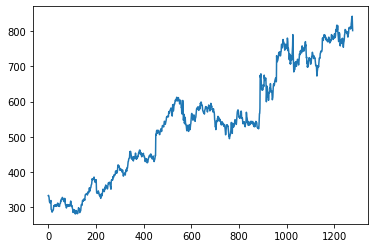

In [12]:
# Visualize the dataset in a plot (train and test):

# Merging both set for visualization purposes:
frames = [train, test]

dataset = pd.concat(frames, ignore_index = True)

# Visualizing the result:
plt.plot(dataset)
plt.show()

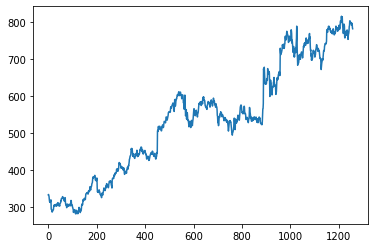

In [13]:
# Visualize the train dataset:

plt.plot(train)
plt.show()

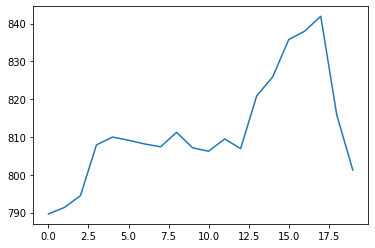

In [14]:
# Visualize the test dataset:

plt.plot(test)
plt.show()

## Prepare the dataset

In [15]:
# Normalize the train and test dataset as preparation for RNN model:

# Creating scaler object:
scaler = MinMaxScaler()

# Transforming dataset:
dataset = scaler.fit_transform(dataset)

In [16]:
# Checking the results after normalization:

dataset[:5]

array([[0.09205692],
       [0.09391162],
       [0.08834754],
       [0.08481649],
       [0.07326033]])

In [17]:
# Manually splitting the dataset into train and test segments:

train = dataset[:1258]
test = dataset[1258:]

In [18]:
# Checking the shape of the train and test segments:

train.shape, test.shape

((1258, 1), (20, 1))

# 2. Many to One

-  Write or reuse a function to segment the dataset in the appropriate format 
- Tip: split_sequence(dataset, n_steps_in):

In [19]:
# Inserting the split_sequence function:

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

- Use the function on the dataset and print the newly segmented data.
- use n_steps_in = 5

In [20]:
# Spliting the train and test dataset in the appropriate segments:

n_steps_in = 5

trainX, trainY = split_sequence(train, n_steps = n_steps_in)
testX, testY = split_sequence(test, n_steps = n_steps_in)

In [21]:
# Checking the shape after spiting the datasets:

trainX.shape, trainY.shape, testX.shape, testY.shape

((1253, 5, 1), (1253, 1), (15, 5, 1), (15, 1))

In [22]:
# Summarize the data:

for i in range(5):
  print(trainX[i], trainY[i])

[[0.09205692]
 [0.09391162]
 [0.08834754]
 [0.08481649]
 [0.07326033]] [0.06154367]
[[0.09391162]
 [0.08834754]
 [0.08481649]
 [0.07326033]
 [0.06154367]] [0.05762029]
[[0.08834754]
 [0.08481649]
 [0.07326033]
 [0.06154367]
 [0.05762029]] [0.06072333]
[[0.08481649]
 [0.07326033]
 [0.06154367]
 [0.05762029]
 [0.06072333]] [0.05544459]
[[0.07326033]
 [0.06154367]
 [0.05762029]
 [0.06072333]
 [0.05544459]] [0.05992082]


In [23]:
# Reshape the data to be appropriate for trianing the RNN model:

# Reshape from [samples, timesteps] into [samples, timesteps, features]:
n_features = 1
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], n_features)
testX = testX.reshape(testX.shape[0], testX.shape[1], n_features)

In [24]:
# Checking the reshaped version of the train dataset:

trainX.shape, testX.shape

((1253, 5, 1), (15, 5, 1))

## Create the model

- create and fit the RNN network. 
- Use LSTM with 60 neurons, RELU activation function, MAE as a loss, and SGD as optimizer.

In [25]:
# Create RNN model object:

model = Sequential()
model.add(LSTM(60, activation = 'relu', input_shape = (n_steps_in, n_features)))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60)                14880     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compiling the RNN model:

model.compile(optimizer = 'SGD', loss = 'mae')

### Define the callbacks

- Callback1 - to save the best model in a file : "best_RNN.pt".
- Callback2 - to stop if there is no improvement in 15 epochs.

In [27]:
# Creating callbacks to make training of the model more flexible:

callback1 = ModelCheckpoint('best_RNN.pt', monitor = 'loss', save_best_only = True, mode = 'min', verbose = 1)
callback2 = EarlyStopping(patience = 15, monitor = 'loss', mode = 'min')
callback_list = [callback1, callback2]

### Train the model and use the callbacks
 - epoch = 150, batch size is 1

In [28]:
# Train the model:

history_m1 = model.fit(trainX, trainY,
                       epochs = 150,
                       batch_size = 1,
                       callbacks = callback_list,
                       verbose = 1 
                       )
print('Training Finished!')

Epoch 1/150
1253/1253 [==============================] - 5s 4ms/step - loss: 0.1353

Epoch 00001: loss improved from inf to 0.06497, saving model to best_RNN.pt
INFO:tensorflow:Assets written to: best_RNN.pt/assets
Epoch 2/150
1253/1253 [==============================] - 4s 4ms/step - loss: 0.0208

Epoch 00002: loss improved from 0.06497 to 0.02018, saving model to best_RNN.pt
INFO:tensorflow:Assets written to: best_RNN.pt/assets
Epoch 3/150
1253/1253 [==============================] - 4s 4ms/step - loss: 0.0205

Epoch 00003: loss did not improve from 0.02018
Epoch 4/150
1253/1253 [==============================] - 4s 4ms/step - loss: 0.0204

Epoch 00004: loss improved from 0.02018 to 0.01990, saving model to best_RNN.pt
INFO:tensorflow:Assets written to: best_RNN.pt/assets
Epoch 5/150
1253/1253 [==============================] - 4s 4ms/step - loss: 0.0203

Epoch 00005: loss improved from 0.01990 to 0.01968, saving model to best_RNN.pt
INFO:tensorflow:Assets written to: best_RNN.pt/ass

## Evaluate the model on the train and test data

In [29]:
# Loading the best model 'best_RNN.pt':

m1 = load_model('/content/best_RNN.pt')

In [30]:
# Making predictions with the model:

trainPredict = m1.predict(trainX)
testPredict = m1.predict(testX)
testPredict[:5]

array([[0.9504337 ],
       [0.95001894],
       [0.9485874 ],
       [0.94722694],
       [0.95256025]], dtype=float32)

In [31]:
# Invert the predictions made by the model:

trainPredict_ = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform(trainY)
testPredict_ = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform(testY)
testPredict_[:5]

array([[814.1562 ],
       [813.92365],
       [813.1209 ],
       [812.35803],
       [815.34863]], dtype=float32)

In [32]:
# Chekcing the shape of inverted predictions:

trainPredict_.shape, trainY_.shape, testPredict_.shape, testY_.shape

((1253, 1), (1253, 1), (15, 1), (15, 1))

### Evaluate the model

In [33]:
# Calculate root mean squared error and mean absolute error on the train and test datasets:

# Calculate root mean squared error:
trainScore = math.sqrt(mean_squared_error(trainY_[:,0], trainPredict_[:,0]))
print('Train RMSE: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_[:,0], testPredict_[:,0]))
print('Test RMSE: %.2f RMSE' % (testScore))

print('\nTrain MAE: %.2f MAE' % (mean_absolute_error(trainY_[:,0], trainPredict_[:,0])))
print('Test MAE: %.2f MAE' % (mean_absolute_error(testY_[:,0], testPredict_[:,0])))

Train RMSE: 11.17 RMSE
Test RMSE: 10.24 RMSE

Train MAE: 9.17 MAE
Test MAE: 7.38 MAE


### Visualize the predictions in a single graph

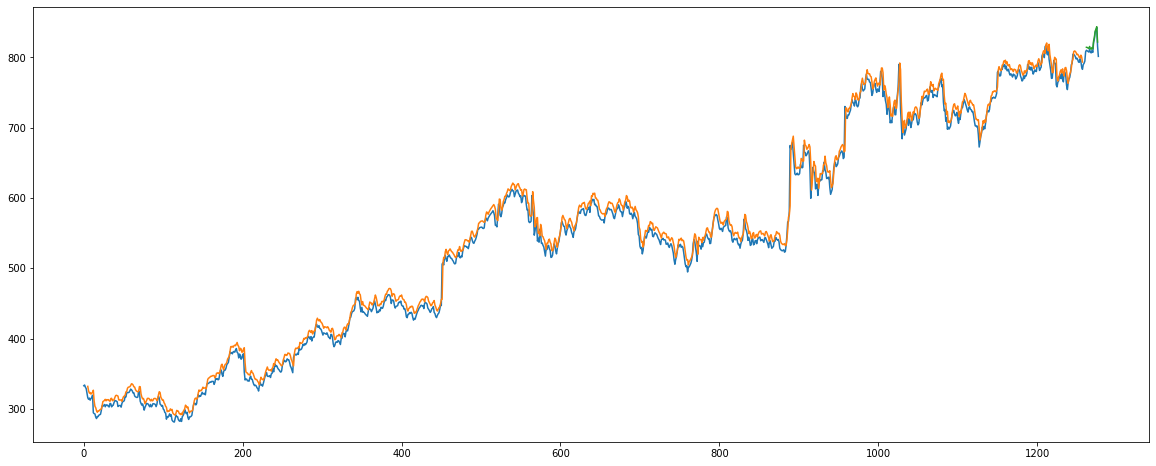

In [34]:
# Visualizing the predictions:

# Shift train predictions for plotting:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_steps_in:len(trainPredict_)+n_steps_in, :] = trainPredict_

# Shift test predictions for plotting:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_)+(n_steps_in*2)-1:len(dataset)-1, :] = testPredict_

# Plot baseline and predictions:
plt.figure(figsize = (20, 8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# 3. Stacked RNN, LSTM

Create a stacked RNN/LSTM with 3 LSTM layers.
The other parameters are the same as in the example before.

In [35]:
# Create  RNN/LSTM with 3 LSTM layers model object:

model_stack = Sequential()
model_stack.add(LSTM(60, activation = 'relu', input_shape = (n_steps_in, n_features), return_sequences = True))
model_stack.add(LSTM(60, activation = 'relu', return_sequences = True))
model_stack.add(LSTM(60, activation = 'relu'))
model_stack.add(Dense(1))
model_stack.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 60)             14880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 60)             29040     
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 73,021
Trainable params: 73,021
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compiling the RNN model:

model_stack.compile(optimizer = 'SGD', loss = 'mae')

In [37]:
# Creating callbacks to make training of the model more flexible:

callback1 = ModelCheckpoint('best_RNN/LSTM_3.pt', monitor = 'loss', save_best_only = True, mode = 'min', verbose = 1)
callback2 = EarlyStopping(patience = 15, monitor = 'loss', mode = 'min')
callback_list = [callback1, callback2]

In [38]:
# Train the model:

history_m2 = model_stack.fit(trainX, trainY,
                             epochs = 150,
                             batch_size = 1,
                             callbacks = callback_list,
                             verbose = 1 
                             )
print('Training Finished!')

Epoch 1/150
1253/1253 [==============================] - 12s 8ms/step - loss: 0.2335

Epoch 00001: loss improved from inf to 0.22252, saving model to best_RNN/LSTM_3.pt
INFO:tensorflow:Assets written to: best_RNN/LSTM_3.pt/assets
Epoch 2/150
1253/1253 [==============================] - 10s 8ms/step - loss: 0.1826

Epoch 00002: loss improved from 0.22252 to 0.13111, saving model to best_RNN/LSTM_3.pt
INFO:tensorflow:Assets written to: best_RNN/LSTM_3.pt/assets
Epoch 3/150
1253/1253 [==============================] - 10s 8ms/step - loss: 0.0340

Epoch 00003: loss improved from 0.13111 to 0.03383, saving model to best_RNN/LSTM_3.pt
INFO:tensorflow:Assets written to: best_RNN/LSTM_3.pt/assets
Epoch 4/150
1253/1253 [==============================] - 10s 8ms/step - loss: 0.0320

Epoch 00004: loss improved from 0.03383 to 0.03160, saving model to best_RNN/LSTM_3.pt
INFO:tensorflow:Assets written to: best_RNN/LSTM_3.pt/assets
Epoch 5/150
1253/1253 [==============================] - 10s 8ms/ste

In [39]:
# Loading the best model 'best_RNN/LSTM_3.pt':

m2 = load_model('/content/best_RNN/LSTM_3.pt')

In [40]:
# Making predictions with the model:

trainPredict_stack = m2.predict(trainX)
testPredict_stack  = m2.predict(testX)
testPredict_stack[:5]

array([[0.9251536 ],
       [0.9285219 ],
       [0.9292575 ],
       [0.9289229 ],
       [0.93171763]], dtype=float32)

In [41]:
# Invert the predictions made by the model:

trainPredict_stack_ = scaler.inverse_transform(trainPredict_stack)
trainY_stack_ = scaler.inverse_transform(trainY)
testPredict_stack_ = scaler.inverse_transform(testPredict_stack)
testY_stack_ = scaler.inverse_transform(testY)
testPredict_stack_[:5]

array([[799.9806 ],
       [801.8693 ],
       [802.28186],
       [802.0942 ],
       [803.6613 ]], dtype=float32)

In [42]:
# Chekcing the shape of inverted predictions:

trainPredict_stack_.shape, trainY_stack_.shape, testPredict_stack_.shape, testY_stack_.shape

((1253, 1), (1253, 1), (15, 1), (15, 1))

### Evaluate the model

In [43]:
# Calculate root mean squared error and mean absolute error on the train and test datasets:

# Calculate root mean squared error:
trainScore_stuck = math.sqrt(mean_squared_error(trainY_stack_[:,0], trainPredict_stack_[:,0]))
print('Train RMSE: %.2f RMSE' % (trainScore_stuck))
testScore_stuck = math.sqrt(mean_squared_error(testY_stack_[:,0], testPredict_stack_[:,0]))
print('Test RMSE: %.2f RMSE' % (testScore_stuck))

print('\nTrain MAE: %.2f MAE' % (mean_absolute_error(trainY_stack_[:,0], trainPredict_stack_[:,0])))
print('Test MAE: %.2f MAE' % (mean_absolute_error(testY_stack_[:,0], testPredict_stack_[:,0])))

Train RMSE: 11.71 RMSE
Test RMSE: 13.27 RMSE

Train MAE: 8.84 MAE
Test MAE: 11.67 MAE


### Visualize the predictions

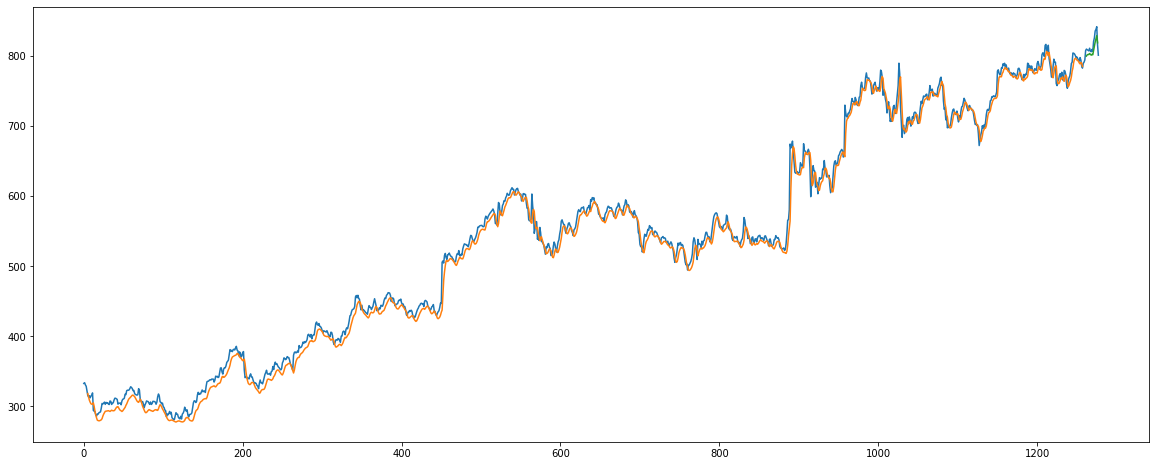

In [44]:
# Visualizing the predictions:

# Shift train predictions for plotting:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_steps_in:len(trainPredict_stack_)+n_steps_in, :] = trainPredict_stack_

# Shift test predictions for plotting:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_stack_)+(n_steps_in*2)-1:len(dataset)-1, :] = testPredict_stack_

# Plot baseline and predictions:
plt.figure(figsize = (20, 8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# 4. One to One

- Create a One to One LSTM model. 
- The training parameters are the same as in the examples before.
- Evaluate the model on the train and test data.
- Visualize the predictions.

In [45]:
# Manually splitting the dataset into train and test segments:

train = dataset[:1258]
test = dataset[1258:]

In [46]:
# Spliting the train and test dataset in the appropriate segments:

n_steps_in = 1

trainX, trainY = split_sequence(train, n_steps = n_steps_in)
testX, testY = split_sequence(test, n_steps = n_steps_in)

In [47]:
# The input to the RNN layer should be in 3D shape i.e. (samples, time-steps, features):

# Train segment:
trainX = trainX.reshape(trainY.shape[0], 1, 1)
trainY = trainY.reshape(trainY.shape[0], 1, 1)

# Test segment:
testX = testX.reshape(testX.shape[0], 1, 1)
testY = testY.reshape(testY.shape[0], 1, 1)

In [48]:
# Checking the shape of the train and test dataset:

trainX.shape, trainY.shape, testX.shape, testY.shape

((1257, 1, 1), (1257, 1, 1), (19, 1, 1), (19, 1, 1))

In [49]:
# Create RNN One_to_One model object:

model_one = Sequential()
model_one.add(LSTM(60, activation = 'relu', input_shape = (n_steps_in, n_features)))
model_one.add(Dense(1))
model_one.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60)                14880     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compiling the RNN model:

model_one.compile(optimizer = 'SGD', loss = 'mae')

In [51]:
# Creating callbacks to make training of the model more flexible:

callback1 = ModelCheckpoint('best_RNN_One.pt', monitor = 'loss', save_best_only = True, mode = 'min', verbose = 1)
callback2 = EarlyStopping(patience = 15, monitor = 'loss', mode = 'min')
callback_list = [callback1, callback2]

In [52]:
# Train the model:

history_m3 = model_one.fit(trainX, trainY,
                           epochs = 150,
                           batch_size = 1,
                           callbacks = callback_list,
                           verbose = 1 
                           )
print('Training Finished!')

Epoch 1/150
1257/1257 [==============================] - 3s 2ms/step - loss: 0.2361

Epoch 00001: loss improved from inf to 0.20823, saving model to best_RNN_One.pt
INFO:tensorflow:Assets written to: best_RNN_One.pt/assets
Epoch 2/150
1257/1257 [==============================] - 2s 2ms/step - loss: 0.1470

Epoch 00002: loss improved from 0.20823 to 0.10730, saving model to best_RNN_One.pt
INFO:tensorflow:Assets written to: best_RNN_One.pt/assets
Epoch 3/150
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0145

Epoch 00003: loss improved from 0.10730 to 0.01409, saving model to best_RNN_One.pt
INFO:tensorflow:Assets written to: best_RNN_One.pt/assets
Epoch 4/150
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0139

Epoch 00004: loss improved from 0.01409 to 0.01376, saving model to best_RNN_One.pt
INFO:tensorflow:Assets written to: best_RNN_One.pt/assets
Epoch 5/150
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0133

Epoch 00005

In [53]:
# Loading the best model 'best_RNN_One.pt':

m3 = load_model('/content/best_RNN_One.pt')

In [54]:
# Making predictions with the model:

trainPredict_one = m3.predict(trainX)
testPredict_one = m3.predict(testX)
testPredict_one[:5]

array([[0.92400587],
       [0.927096  ],
       [0.93277   ],
       [0.95702314],
       [0.9607647 ]], dtype=float32)

In [55]:
# Reshaping the trainY and testY in order to invert the predictions:

trainY = trainY.reshape(-1, 1)
testY = testY.reshape(-1, 1)

In [56]:
# Invert the predictions made by the model:

trainPredict_one_ = scaler.inverse_transform(trainPredict_one)
trainY_one_ = scaler.inverse_transform(trainY)
testPredict_one_ = scaler.inverse_transform(testPredict_one)
testY_one_ = scaler.inverse_transform(testY)
testPredict_one_[:5]

array([[799.33704],
       [801.0698 ],
       [804.25146],
       [817.85114],
       [819.9492 ]], dtype=float32)

In [57]:
# Chekcing the shape of inverted predictions:

trainPredict_one_.shape, trainY_one_.shape, testPredict_one_.shape, testY_one_.shape

((1257, 1), (1257, 1), (19, 1), (19, 1))

In [58]:
# Calculate root mean squared error and mean absolute error on the train and test datasets:

# Calculate root mean squared error:
trainScore_one = math.sqrt(mean_squared_error(trainY_one_[:,0], trainPredict_one_[:,0]))
print('Train RMSE: %.2f RMSE' % (trainScore_one))
testScore_one = math.sqrt(mean_squared_error(testY_one_[:,0], testPredict_one_[:,0]))
print('Test RMSE: %.2f RMSE' % (testScore_one))

print('\nTrain MAE: %.2f MAE' % (mean_absolute_error(trainY_one_[:,0], trainPredict_one_[:,0])))
print('Test MAE: %.2f MAE' % (mean_absolute_error(testY_one_[:,0], testPredict_one_[:,0])))

Train RMSE: 9.87 RMSE
Test RMSE: 12.84 RMSE

Train MAE: 7.36 MAE
Test MAE: 10.14 MAE


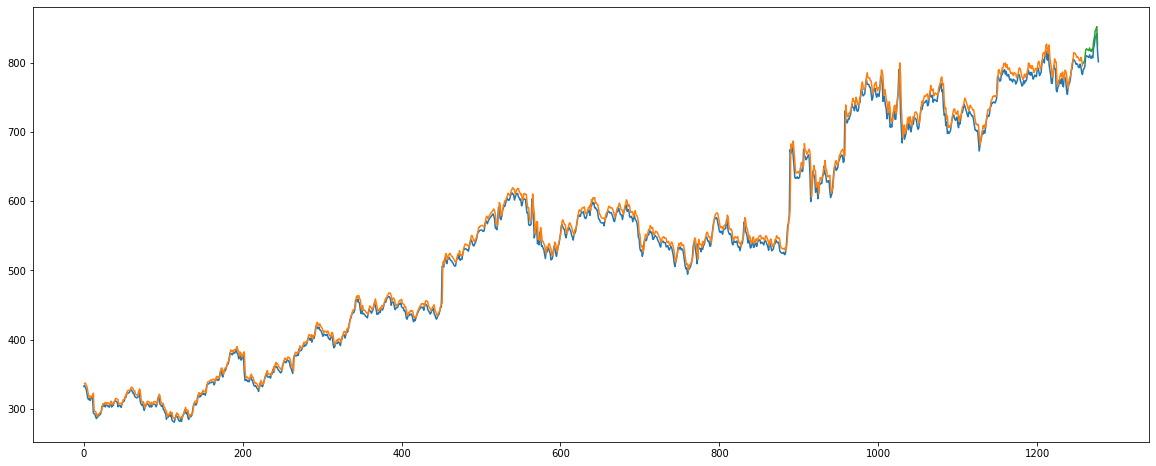

In [59]:
# Visualizing the predictions:

# Shift train predictions for plotting:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_steps_in:len(trainPredict_one_)+n_steps_in, :] = trainPredict_one_

# Shift test predictions for plotting:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_one_)+(n_steps_in*2)-1:len(dataset)-1, :] = testPredict_one_

# Plot baseline and predictions:
plt.figure(figsize = (20, 8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# 5. Many to Many

## Prepare the data in appropriate format

In [60]:
# Manually splitting the dataset into train and test segments:

train = dataset[:1258]
test = dataset[1258:]

In [61]:
# Function that segments the data:

def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [62]:
# Preparing and splitting the dataset:

# Choose a number of time steps:
n_steps_in = 5
n_steps_out = 2
n_features = 1

# Split the dataset into samples:
trainX, trainY = split_sequence(train, n_steps_in, n_steps_out)
testX, testY = split_sequence(test, n_steps_in, n_steps_out)

# Print the first 3 samples for trainX and trainY:
for i in range(3):
	print(testX[i], "Y: " , testY[i])

[[0.90669472]
 [0.90974427]
 [0.91534401]
 [0.93927667]
 [0.94296822]] Y:  [[0.9414702 ]
 [0.93972251]]
[[0.90974427]
 [0.91534401]
 [0.93927667]
 [0.94296822]
 [0.9414702 ]] Y:  [[0.93972251]
 [0.93836716]]
[[0.91534401]
 [0.93927667]
 [0.94296822]
 [0.9414702 ]
 [0.93972251]] Y:  [[0.93836716]
 [0.94519742]]


- There are 2 (n_steps_out) predictions for each data point. 
- Thus, we need to take the predicitons on each 'n_steps_out' step 

In [63]:
# Preparing the test dataset for predictions:

testX = testX[::n_steps_out]
testY = testY[::n_steps_out]

In [64]:
# Checking the shape of the test dataset:

testX.shape, testY.shape

((7, 5, 1), (7, 2, 1))

## Create the model

- Create and fit the RNN network. 
- Use encoder LSTM with 100 neurons, decoder LSTM with 100 enaurons.
- RELU activation function, MAE as a loss, and RELU as optimizer.

In [65]:
# Create RNN/LSTM with 100 neurons (on 'in' and 'out') model object:

model_many = Sequential()
model_many.add(LSTM(100, activation='relu', input_shape = (n_steps_in, n_features)))
model_many.add(RepeatVector(n_steps_out))
model_many.add(LSTM(100, activation='relu', return_sequences=True))
model_many.add(Dense(1))
model_many.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               40800     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 100)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 2, 100)            80400     
_________________________________________________________________
dense_3 (Dense)              (None, 2, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Compiling the RNN model:

model_many.compile(optimizer = 'SGD', loss = 'mae')

In [67]:
# Creating callbacks to make training of the model more flexible:

callback1 = ModelCheckpoint('best_RNN_EN_DE.pt', monitor = 'loss', save_best_only = True, mode = 'min', verbose = 1)
callback2 = EarlyStopping(patience = 15, monitor = 'loss', mode = 'min')
callback_list = [callback1, callback2]

In [68]:
# Train the model:

history_m4 = model_many.fit(trainX, trainY,
                            epochs = 150,
                            batch_size = 1,
                            callbacks = callback_list,
                            verbose = 1 
                            )
print('Training Finished!')

Epoch 1/150
1252/1252 [==============================] - 7s 5ms/step - loss: 0.2359

Epoch 00001: loss improved from inf to 0.20894, saving model to best_RNN_EN_DE.pt
INFO:tensorflow:Assets written to: best_RNN_EN_DE.pt/assets
Epoch 2/150
1252/1252 [==============================] - 6s 5ms/step - loss: 0.1342

Epoch 00002: loss improved from 0.20894 to 0.09544, saving model to best_RNN_EN_DE.pt
INFO:tensorflow:Assets written to: best_RNN_EN_DE.pt/assets
Epoch 3/150
1252/1252 [==============================] - 6s 5ms/step - loss: 0.0568

Epoch 00003: loss improved from 0.09544 to 0.05482, saving model to best_RNN_EN_DE.pt
INFO:tensorflow:Assets written to: best_RNN_EN_DE.pt/assets
Epoch 4/150
1252/1252 [==============================] - 6s 5ms/step - loss: 0.0529

Epoch 00004: loss improved from 0.05482 to 0.05207, saving model to best_RNN_EN_DE.pt
INFO:tensorflow:Assets written to: best_RNN_EN_DE.pt/assets
Epoch 5/150
1252/1252 [==============================] - 6s 5ms/step - loss: 0.0

## Make the predictions

In [69]:
# Loading the best model 'best_RNN_EN_DE.pt':

m4 = load_model('/content/best_RNN_EN_DE.pt')


In [70]:
# Making predictions with the model:

trainPredict_many = m4.predict(trainX)
testPredict_many = m4.predict(testX)
testPredict_many[:5]

array([[[0.9294017],
        [0.928719 ]],

       [[0.9330366],
        [0.931797 ]],

       [[0.9356624],
        [0.9343815]],

       [[0.9314471],
        [0.9299608]],

       [[0.9321565],
        [0.9307374]]], dtype=float32)

### Calculate the RMSE and MAE for the train and test data

Note: Reshape the predictions in approriate format

In [71]:
# Reshaping the predictions in order to invert them properly:

# Train segment:
trainPredict_many = trainPredict_many.reshape(trainPredict_many.shape[0] * trainPredict_many.shape[1], 1)
trainY = trainY.reshape(trainY.shape[0] * trainY.shape[1], 1)

# Test segment:
testPredict_many = testPredict_many.reshape(testPredict_many.shape[0] * testPredict_many.shape[1], 1)
testY = testY.reshape(testY.shape[0] * testY.shape[1], 1)

In [72]:
# Invert the predictions made by the model:

trainPredict_many_ = scaler.inverse_transform(trainPredict_many)
trainY_many_ = scaler.inverse_transform(trainY)
testPredict_many_ = scaler.inverse_transform(testPredict_many)
testY_many_ = scaler.inverse_transform(testY)
testPredict_many_[:5]

array([[802.36273],
       [801.9799 ],
       [804.40094],
       [803.7059 ],
       [805.8733 ]], dtype=float32)

In [73]:
# Chekcing the shape of inverted predictions:

trainPredict_many_.shape, trainY_many_.shape, testPredict_many_.shape, testY_many_.shape

((2504, 1), (2504, 1), (14, 1), (14, 1))

In [74]:
# Calculate root mean squared error and mean absolute error on the train and test datasets:

# Calculate root mean squared error:
trainScore_many = math.sqrt(mean_squared_error(trainY_many_[:,0], trainPredict_many_[:,0]))
print('Train RMSE: %.2f RMSE' % (trainScore_many))
testScore_many = math.sqrt(mean_squared_error(testY_many_[:,0], testPredict_many_[:,0]))
print('Test RMSE: %.2f RMSE' % (testScore_many))

print('\nTrain MAE: %.2f MAE' % (mean_absolute_error(trainY_many_[:,0], trainPredict_many_[:,0])))
print('Test MAE: %.2f MAE' % (mean_absolute_error(testY_many_[:,0], testPredict_many_[:,0])))

Train RMSE: 12.10 RMSE
Test RMSE: 12.68 RMSE

Train MAE: 9.01 MAE
Test MAE: 10.28 MAE


### Visualize the predictions

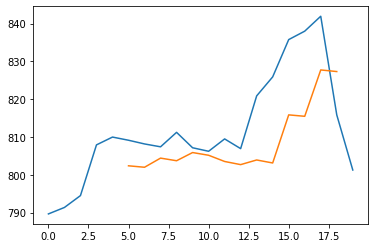

In [75]:
# Plot the test predicitons and the whole test dataset:
testPredictPlot = np.empty_like(test)
testPredictPlot[:, :] = np.nan
testPredictPlot[(n_steps_in):len(test)-1, :] = testPredict_many_

# plot baseline and predictions
plt.plot(scaler.inverse_transform(test))
plt.plot(testPredictPlot)
plt.show()

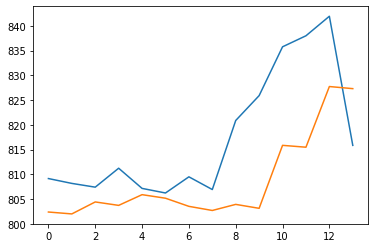

In [76]:
# Plot only the test predicitons (no empty predictions at the beginning and the end):

plt.plot(scaler.inverse_transform(testY))
plt.plot(testPredict_many_)
plt.show()

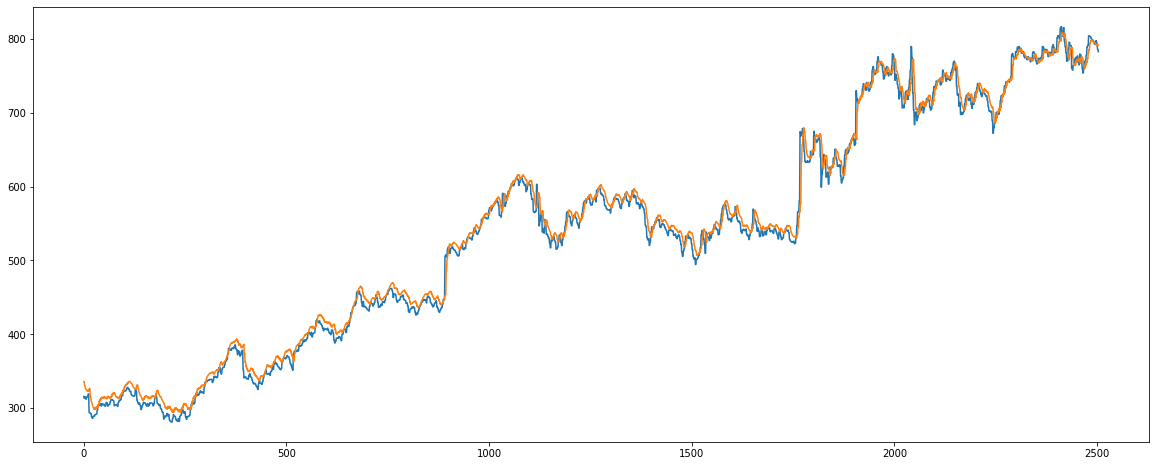

In [77]:
# Plot the train dataset and predicitons:

plt.figure(figsize = (20, 8))
plt.plot(scaler.inverse_transform(trainY))
plt.plot(trainPredict_many_)
plt.show()

# 6. Summary

Comapre the results (RMSE) in one table
- One to One
- Many to One
- Many to One - Stacked
- Many to Many

In [97]:
data = {'Metric':  ['RMSE_train', 'RMSE_test'],
        'One_to_One ': [trainScore_one, testScore_one],
        'Many_to_One ' : [trainScore, testScore],
        'Many_to_One_Stacked' : [trainScore_stuck, testScore_stuck],
        'Many_to_Many': [trainScore_many, testScore_many]
        }

comparison = pd.DataFrame(data)

comparison

,Metric,One_to_One,Many_to_One,Many_to_One_Stacked,Many_to_Many
0,RMSE_train,9.866263,11.172463,11.707010,12.100292
1,RMSE_test,12.840369,10.241795,13.272408,12.679820


#  [OPTIONAL] 7. Create the best performing Many to One model.

Use different parameters of the newtork, different optimizers, ...

In [79]:
# Manually splitting the dataset into train and test segments:

train = dataset[:1258]
test = dataset[1258:]

In [80]:
# Inserting the split_sequence function:

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [81]:
# Spliting the train and test dataset in the appropriate segments:

n_steps_in = 5

trainX, trainY = split_sequence(train, n_steps = n_steps_in)
testX, testY = split_sequence(test, n_steps = n_steps_in)

In [82]:
# Checking the shape after spiting the datasets:

trainX.shape, trainY.shape, testX.shape, testY.shape

((1253, 5, 1), (1253, 1), (15, 5, 1), (15, 1))

In [83]:
# Reshape the data to be appropriate for trianing the RNN model:

# Reshape from [samples, timesteps] into [samples, timesteps, features]:
n_features = 1
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], n_features)
testX = testX.reshape(testX.shape[0], testX.shape[1], n_features)

In [84]:
# Checking the reshaped version of the train dataset:

trainX.shape, testX.shape

((1253, 5, 1), (15, 5, 1))

In [85]:
# Create RNN model object:

model_opt = Sequential()
model_opt.add(LSTM(60, activation = 'relu', input_shape = (n_steps_in, n_features)))
model_opt.add(Dense(1))
model_opt.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 60)                14880     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Compiling the RNN model:

model_opt.compile(optimizer = 'adam', loss = 'mae')

In [87]:
# Creating callbacks to make training of the model more flexible:

callback1 = ModelCheckpoint('best_RNN_opt.pt', monitor = 'loss', save_best_only = True, mode = 'min', verbose = 1)
callback2 = EarlyStopping(patience = 15, monitor = 'loss', mode = 'min')
callback_list = [callback1, callback2]

In [88]:
# Train the model:

history_opt = model_opt.fit(trainX, trainY,
                            epochs = 100,
                            batch_size = 1,
                            callbacks = callback_list,
                            verbose = 1 
                            )
print('Training Finished!')

Epoch 1/100
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0681

Epoch 00001: loss improved from inf to 0.03182, saving model to best_RNN_opt.pt
INFO:tensorflow:Assets written to: best_RNN_opt.pt/assets
Epoch 2/100
1253/1253 [==============================] - 4s 4ms/step - loss: 0.0196

Epoch 00002: loss improved from 0.03182 to 0.02002, saving model to best_RNN_opt.pt
INFO:tensorflow:Assets written to: best_RNN_opt.pt/assets
Epoch 3/100
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0191

Epoch 00003: loss improved from 0.02002 to 0.01879, saving model to best_RNN_opt.pt
INFO:tensorflow:Assets written to: best_RNN_opt.pt/assets
Epoch 4/100
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0169

Epoch 00004: loss improved from 0.01879 to 0.01719, saving model to best_RNN_opt.pt
INFO:tensorflow:Assets written to: best_RNN_opt.pt/assets
Epoch 5/100
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0156

Epoch 00005

In [89]:
# Loading the best model 'best_RNN_opt.pt':

m5 = load_model('/content/best_RNN_opt.pt')

In [90]:
# Making predictions with the model:

trainPredict_opt = m5.predict(trainX)
testPredict_opt = m5.predict(testX)
testPredict_opt[:5]

array([[0.9474669 ],
       [0.9461984 ],
       [0.9449254 ],
       [0.9439386 ],
       [0.95186543]], dtype=float32)

In [91]:
# Invert the predictions made by the model:

trainPredict_opt_ = scaler.inverse_transform(trainPredict_opt)
trainY_opt_ = scaler.inverse_transform(trainY)
testPredict_opt_ = scaler.inverse_transform(testPredict_opt)
testY_opt_= scaler.inverse_transform(testY)
testPredict_opt_[:5]

array([[812.4926 ],
       [811.7813 ],
       [811.06744],
       [810.5141 ],
       [814.959  ]], dtype=float32)

In [92]:
# Chekcing the shape of inverted predictions:

trainPredict_opt_.shape, trainY_opt_.shape, testPredict_opt_.shape, testY_opt_.shape

((1253, 1), (1253, 1), (15, 1), (15, 1))

In [93]:
# Calculate root mean squared error and mean absolute error on the train and test datasets:

# Calculate root mean squared error:
trainScore_opt = math.sqrt(mean_squared_error(trainY_opt_[:,0], trainPredict_opt_[:,0]))
print('Train RMSE: %.2f RMSE' % (trainScore_opt))
testScore_opt = math.sqrt(mean_squared_error(testY_opt_[:,0], testPredict_opt_[:,0]))
print('Test RMSE: %.2f RMSE' % (testScore_opt))

print('\nTrain MAE: %.2f MAE' % (mean_absolute_error(trainY_opt_[:,0], trainPredict_opt_[:,0])))
print('Test MAE: %.2f MAE' % (mean_absolute_error(testY_opt_[:,0], testPredict_opt_[:,0])))

Train RMSE: 7.58 RMSE
Test RMSE: 9.59 RMSE

Train MAE: 4.70 MAE
Test MAE: 6.10 MAE


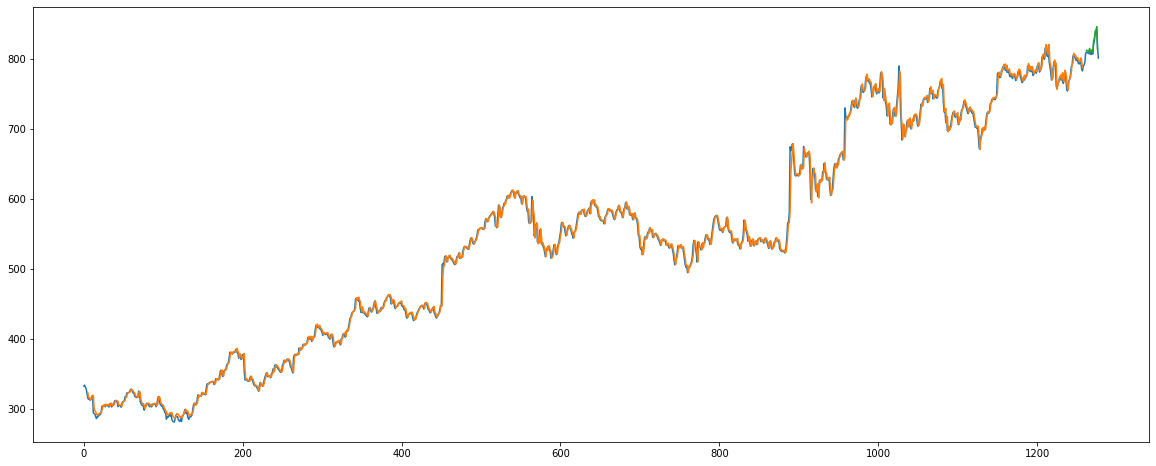

In [94]:
# Visualizing the predictions:

# Shift train predictions for plotting:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_steps_in:len(trainPredict_opt_)+n_steps_in, :] = trainPredict_opt_

# Shift test predictions for plotting:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_opt_)+(n_steps_in*2)-1:len(dataset)-1, :] = testPredict_opt_

# Plot baseline and predictions:
plt.figure(figsize = (20, 8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [96]:
data = {'Metric':  ['RMSE_train', 'RMSE_test'],
        'One_to_One ': [trainScore_one, testScore_one],
        'Many_to_One ' : [trainScore, testScore],
        'Many_to_One_Stacked' : [trainScore_stuck, testScore_stuck],
        'Many_to_Many': [trainScore_many, testScore_many],
        'Many_to_One_Best': [trainScore_opt, testScore_opt]
        }

comparison = pd.DataFrame(data)

comparison

,Metric,One_to_One,Many_to_One,Many_to_One_Stacked,Many_to_Many,Many_to_One_Best
0,RMSE_train,9.866263,11.172463,11.707010,12.100292,7.580224
1,RMSE_test,12.840369,10.241795,13.272408,12.679820,9.587700
